<a href="https://colab.research.google.com/github/TanviGarg13/FutureIntern_AI_005/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
# Import Libraries and Define Helper Functions
import torch
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Helper function to load an image and apply necessary transformations
def load_image(image_path, size=512):
    image = Image.open(image_path).convert('RGB')  # Open and convert image to RGB
    preprocess = transforms.Compose([
        transforms.Resize(size),  # Resize image
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
    ])
    return preprocess(image).unsqueeze(0).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Helper function to display an image tensor
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().squeeze(0)  # Move tensor to CPU, remove batch dimension
    image = transforms.ToPILImage()(image)  # Convert tensor to PIL image
    plt.imshow(image)  # Display the image
    if title:
        plt.title(title)
    plt.show()

# Helper function to compute the Gram matrix for style loss
def gram_matrix(tensor):
    batch_size, f_map_num, h, w = tensor.size()  # Get dimensions of the tensor
    features = tensor.view(batch_size * f_map_num, h * w)  # Reshape tensor
    gram = torch.mm(features, features.t())  # Compute Gram matrix
    return gram.div(batch_size * f_map_num * h * w)  # Normalize

In [3]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from torchvision.models import VGG19_Weights

# Load a pre-trained VGG19 model with updated weights parameter
weights = VGG19_Weights.IMAGENET1K_V1  # You can also use VGG19_Weights.DEFAULT for the latest weights
model = models.vgg19(weights=weights).features.to(device).eval()

In [8]:
# Load the content image and style image, ensuring they are on the correct device
content_img = load_image('unsplash1.jpg').to(device)
style_img = load_image('unsplash2.jpg').to(device)

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# Define a loss class for content
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()  # Store target features, no gradient needed

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)  # Compute content loss
        return input

# Define a loss class for style
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()  # Compute target Gram matrix

    def forward(self, input):
        G = gram_matrix(input)  # Compute Gram matrix for input
        self.loss = F.mse_loss(G, self.target)  # Compute style loss
        return input

In [13]:
# Function to create a model with content and style loss modules
def get_style_model_and_losses(cnn, style_img, content_img):
    cnn = cnn.to(device).eval()  # Move model to device and set to evaluation mode
    normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    # Resize style image to match content image dimensions
    style_img = F.interpolate(style_img, size=content_img.shape[-2:], mode='bilinear', align_corners=False)

    normalization = nn.Sequential(
        nn.Conv2d(3, 3, kernel_size=1),
        nn.InstanceNorm2d(3, affine=True)
    ).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # Add content loss
        if name == 'conv_4':
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # Add style loss
        if name in ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']:
            target_feature = model(style_img).detach() # Pass the resized style image
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:i + 1]

    return model, style_losses, content_losses

In [14]:
# Function to run style transfer
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                      style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        def closure():
            input_img.data.clamp_(0, 1)  # Clamp values to valid range

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            loss = style_score * style_weight + content_score * content_weight
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run[0]))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                     style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)  # Clamp final output to valid range

    return input_img

Building the style transfer model..
Optimizing..
run 50:
Style Loss : 0.000030 Content Loss: 11.676895

run 100:
Style Loss : 0.000015 Content Loss: 10.340895

run 150:
Style Loss : 0.000012 Content Loss: 9.438254

run 200:
Style Loss : 0.000010 Content Loss: 8.826137

run 250:
Style Loss : 0.000008 Content Loss: 8.447785

run 300:
Style Loss : 0.001597 Content Loss: 13.650244



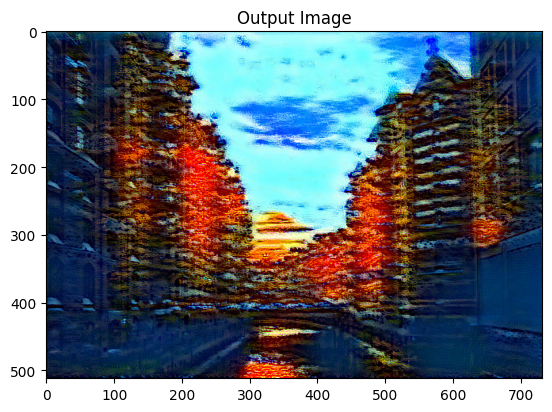

In [15]:
# Clone content image to use as the initial input
input_img = content_img.clone().to(device)

# Perform the style transfer
output_img = run_style_transfer(model, content_img, style_img, input_img)

# Display the output image
imshow(output_img, title='Output Image')